## imports

In [4]:
import numpy as np
from numpy import linalg as l
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tqdm import tqdm

## functions

In [5]:
def initial_state(a):
    uy = np.linspace(-np.sqrta(a), np.sqrt(a), 1001)
    y = np.sign(uy) * uy ** 2
    c = np.linspace(-0.05, 0.05, 20)

    Y, Y_ = np.meshgrid(y, y, indexing='ij')

    step_y1 = y - np.roll(y, 1)
    step_y2 = np.roll(y, -1) - y
    step_y1[0] = step_y2[-1] = 0
    step_y = (step_y1 + step_y2) / 2 #trapezoidal rule

    u = np.tanh(y)
    dev2u = - 2 * np.tanh(y) / (np.cosh(y) ** 2)

    min_Y = np.minimum(Y, Y_)
    max_Y = np.maximum(Y, Y_)

    return y, c, u, dev2u, step_y, min_Y, max_Y

In [6]:
def count_eigen(k, a, c, max_Y, u, min_Y, dev2u, step_y):
    eps = 1e-15
    green = - (np.exp(- k * max_Y) - np.exp(- k * (2 * a - max_Y))) * \
              (np.exp(k * min_Y) - np.exp(- k * (2 * a + min_Y))) / \
              (1 - np.exp(- 4 * k * a)) / 2 / k
    
    residue = np.zeros_like(green, dtype=np.complex128)
    residue[:, len(u) // 2 + 1] = (4 * np.pi * c *
                                   green[:, len(u) // 2 + 1])
    
    kernel =  dev2u * green * step_y / (u - 1j * c + eps) 
    
    if (c < 0):
        kernel += residue
        
    if c == 0:
        kernel += residue / 2
    
    val, vect = l.eig(kernel)
    return val, vect, residue

In [44]:
def find_lambdas(k, a, c, max_Y, u, min_Y, dev2u, step_y):
    lambdas = []
    for i in range(len(c)):
        vals, vect, res = count_eigen(k, a, c[i], max_Y, u, min_Y, dev2u, step_y)
        vals_sorted = np.sort(np.real(vals))
        lambdas.append(vals_sorted[-1])
      
    return np.array(lambdas)

In [52]:
def find_c(k, a, c, max_Y, u, min_Y, dev2u, step_y):
    lambdas = find_lambdas(k, a, c, max_Y, u, min_Y, dev2u, step_y)
    idx = np.abs(lambdas - 1).argmin()
    return c[idx]

## initial state

In [46]:
a = 5
k = 0.9907
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
lambdas_unstable = find_lambdas(k, a, c, max_Y, u, min_Y, dev2u, step_y)

In [48]:
k = 0.9997
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
lambdas_edge= find_lambdas(k, a, c, max_Y, u, min_Y, dev2u, step_y)

In [47]:
k = 1.0087
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
lambdas_stable= find_lambdas(k, a, c, max_Y, u, min_Y, dev2u, step_y)

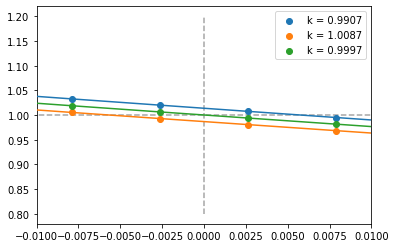

In [50]:
plt.plot([c.min(), c.max()], [1, 1], ls='--', c='grey', alpha=0.7)
plt.plot([0, 0], [0.8, 1.2], ls='--', c='grey', alpha=0.7)
plt.scatter(c, lambdas_unstable, label=f'k = 0.9907', zorder=100)
plt.plot(c, lambdas_unstable, zorder=101)

plt.scatter(c, lambdas_stable, label=f'k = 1.0087', zorder=100)
plt.plot(c, lambdas_stable, zorder=101)

plt.scatter(c, lambdas_edge, label=f'k = 0.9997', zorder=100)
plt.plot(c, lambdas_edge, zorder=101)

plt.xlim(-0.01, 0.01)
plt.legend()

In [55]:
c_array = []
y, c, u, dev2u, step_y, min_Y, max_Y = initial_state(a)
k_array = np.linspace(0.9, 1.1, 50)
for k in tqdm(k_array):
    c_0 = find_c(k, a, c, max_Y, u, min_Y, dev2u, step_y)
    c_array.append(c_0)

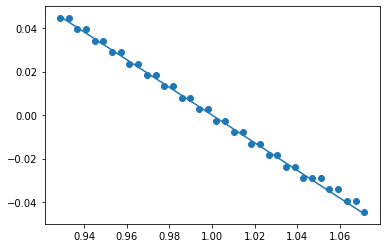

In [73]:
plt.scatter(k_array[7:-7], c_array[7:-7])
plt.plot(k_array[7:-7], (1 - k_array[7:-7]) * 2 / np.pi)